In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import itertools

In [ ]:
load_file_path=os.path.join('/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Mnist', 'Copy of Mnist_result.csv')
print(load_file_path)

save_folder='/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Mnist'

/content/drive/My Drive/2023 InterpretingNN/code/experiment and result stage2/Mnist/Copy of Mnist_result.csv


In [ ]:
# Load the CSV file into a dataframe
dataframe = pd.read_csv(load_file_path)

add flops col

In [ ]:
def preprocess_dataframe(df, flops_dict):
    # Step 1: Modify column names and remove specific columns
    df.rename(columns={'conv1x1_3x3.1': 'conv1x1_3x3', 'conv1x1_5x5.1': 'conv1x1_5x5'}, inplace=True)
    df.drop(columns=['conv1x1_3x3.0', 'conv1x1_5x5.0'], inplace=True)

    # Step 2: Add FLOPS columns
    for col, value in flops_dict.items():
        df[col] = value

    return df

# Example usage:
flops_dict = {"conv1x1FLOPS": 0.012544, "conv1x1_3x3FLOPS": 0.909, "conv1x1_5x5FLOPS": 2.515, "totalFLOPS": 13.274}
df = preprocess_dataframe(dataframe, flops_dict)

normalize layer feature attribution in this stack

In [ ]:
def normalize_feature_attribution_final(df):
    """
    Final modification of the normalization of feature attributions for each layer.

    Parameters:
    df (DataFrame): The dataframe containing the feature attributions.

    Returns:
    DataFrame: A modified dataframe with normalized feature attributions for each layer.
    """
    # Columns to be normalized
    layers = ['conv1x1', 'conv1x1_3x3', 'conv1x1_5x5']

    # New sum calculation using specific layers
    df['sum_feature_attr'] = df[layers].sum(axis=1)

    # Normalize each layer by dividing by the new sum of feature attributions
    for layer in layers:
        df[f'norm_{layer}'] = df[layer] / df['sum_feature_attr']

    df.drop(['sum_feature_attr','conv1x1',	'conv1x1_3x3',	'conv1x1_5x5'], axis=1, inplace=True)

    return df

# Example usage of the final modified function
normalized_final_df = normalize_feature_attribution_final(df.copy())

get average and normalzied variance for each combination of hyperparameter

In [ ]:
def calculate_normalized_variance(df, method, flops_dict):
    """
    Modified combined function to calculate the average and normalized variance of each layer's feature attribution
    for a given method, including both average and variance in one dataframe, along with average accuracy after each epoch.
    This version also includes FLOPS information.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    method (str): The method to filter the data ('deeplift' or 'integrated_gradients').
    flops_dict (dict): Dictionary containing FLOPS values for different layers.

    Returns:
    DataFrame: A dataframe with the average and normalized variance for each layer combined, and average accuracy after each epoch, including FLOPS info.
    """
    # Filter the dataframe based on the method
    filtered_df = df[df['method'] == method]

    # Columns for which to calculate average and normalized variance, excluding certain layers
    layers = ['norm_conv1x1', 'norm_conv1x1_3x3', 'norm_conv1x1_5x5']
    accuracy_columns = ['train accuracy epoch0', 'train accuracy epoch1', 'train accuracy epoch2', 'test accuracy epoch0', 'test accuracy epoch1', 'test accuracy epoch2']

    # Group by hyperparameters and calculate mean and variance for feature attributions and accuracy
    grouped = filtered_df.groupby(['initial_lr', 'optimizer', 'criterion', 'train_data_used', 'train_set_shuffle', 'train_batch_size'])
    avg_norm = grouped[layers].mean()
    var_norm = grouped[layers].var()
    avg_acc = grouped[accuracy_columns].mean()

    # Calculate normalized variance (variance/mean)
    norm_var = var_norm / avg_norm

    # Combine average and normalized variance into one dataframe
    combined_df = avg_norm.copy()
    for layer in layers:
        combined_df[f'norm_var_{layer}'] = norm_var[layer]

    # Calculate the average normalized variance across the selected layers
    norm_var_layers = [f'norm_var_{layer}' for layer in layers]
    combined_df['avg_normalized_variance'] = combined_df[norm_var_layers].mean(axis=1)

    # Adding average accuracy columns
    for acc_col in accuracy_columns:
        combined_df[acc_col] = avg_acc[acc_col]

    # Add FLOPS information
    for flops_key, flops_value in flops_dict.items():
        combined_df[flops_key] = flops_value

    return combined_df

# Example usage
combined_avg_norm_var_acc_integrated_gradients = calculate_normalized_variance(normalized_final_df, 'integrated_gradients', flops_dict)

In [ ]:
combined_avg_norm_var_acc_integrated_gradients.to_csv(save_folder+"/mnist ig.csv")
combined_avg_norm_var_acc_integrated_gradients=pd.read_csv(save_folder+"/mnist ig.csv")

In [ ]:
def filter_by_accuracy(df, threshold=70.0):
    """
    Function to filter out rows where the average accuracy across epoch 3 (both train and test) is lower than a specified threshold.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    threshold (float): The threshold for average accuracy in epoch 3.

    Returns:
    DataFrame: A filtered dataframe with rows having average epoch 3 accuracy higher than the threshold.
    """
    # Columns representing epoch 3 accuracy
    epoch_2_accuracy_cols = ['train accuracy epoch2', 'test accuracy epoch2']

    # Calculate the average accuracy for epoch 3
    df['avg_accuracy_epoch_2'] = df[epoch_2_accuracy_cols].mean(axis=1)

    # Filter the dataframe based on the threshold
    filtered_df = df[df['avg_accuracy_epoch_2'] >= threshold]

    return filtered_df

# Apply the function to the dataframes for 'deeplift' and 'integrated_gradients'
filtered_integrated_gradients = filter_by_accuracy(combined_avg_norm_var_acc_integrated_gradients)

# Display the first few rows of the filtered dataframes
filtered_integrated_gradients

,initial_lr,optimizer,criterion,train_data_used,train_set_shuffle,train_batch_size,norm_conv1x1,norm_conv1x1_3x3,norm_conv1x1_5x5,norm_var_norm_conv1x1,...,train accuracy epoch1,train accuracy epoch2,test accuracy epoch0,test accuracy epoch1,test accuracy epoch2,conv1x1FLOPS,conv1x1_3x3FLOPS,conv1x1_5x5FLOPS,totalFLOPS,avg_accuracy_epoch_2
0,0.001,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),0.5,False,16,0.620301,0.194518,0.185181,0.040673,...,95.365167,96.523333,91.281,94.324,95.558,0.012544,0.909,2.515,13.274,96.040667
1,0.001,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),0.5,False,64,0.271556,0.352177,0.376267,0.013201,...,95.190667,96.358500,93.199,94.916,95.629,0.012544,0.909,2.515,13.274,95.993750
2,0.001,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),0.5,True,16,0.607346,0.184963,0.207691,0.042573,...,95.515333,96.588333,94.408,95.927,96.473,0.012544,0.909,2.515,13.274,96.530667
3,0.001,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),0.5,True,64,0.280192,0.339752,0.380057,0.013761,...,95.541000,96.504833,94.981,95.907,96.173,0.012544,0.909,2.515,13.274,96.338917
4,0.001,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1.0,False,16,0.639682,0.185142,0.175177,0.049547,...,95.375833,96.560500,92.105,94.944,95.556,0.012544,0.909,2.515,13.274,96.058250
5,0.001,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1.0,False,64,0.271970,0.359548,0.368482,0.012142,...,95.199167,96.367500,93.205,94.896,95.762,0.012544,0.909,2.515,13.274,96.064750
6,0.001,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1.0,True,16,0.593007,0.206665,0.200328,0.049991,...,95.512333,96.560000,94.536,95.944,96.354,0.012544,0.909,2.515,13.274,96.457000
7,0.001,<class 'torch.optim.adam.Adam'>,CrossEntropyLoss(),1.0,True,64,0.272855,0.350417,0.376728,0.015610,...,95.524167,96.508167,94.997,95.781,96.202,0.012544,0.909,2.515,13.274,96.355083
8,0.001,<class 'torch.optim.sgd.SGD'>,CrossEntropyLoss(),0.5,False,16,0.278889,0.268477,0.452634,0.008609,...,91.976000,93.705500,90.640,92.726,94.014,0.012544,0.909,2.515,13.274,93.859750
9,0.001,<class 'torch.optim.sgd.SGD'>,CrossEntropyLoss(),0.5,False,64,0.337265,0.245371,0.417364,0.006980,...,88.964500,90.237833,87.225,89.783,90.854,0.012544,0.909,2.515,13.274,90.545917


# Graph

In [ ]:
def plot_variance_for_multiple_hyperparam_values(df, hyperparam, variables):
    """
    Plots bar graphs of the average variance of each layer and the overall average variance
    for multiple values of a given hyperparameter.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    hyperparam (str): The hyperparameter to vary.
    variables (list): A list of values for the hyperparameter to compare.

    Returns:
    None: The function plots graphs directly.
    """
    # Check if the hyperparameter exists in the dataframe
    if hyperparam not in df.columns:
        print(f"Column '{hyperparam}' not found in dataframe.")
        return

    # Extracting variance columns
    variance_columns = [col for col in df.columns if 'norm_var' in col]
    variance_columns.append('avg_normalized_variance')

    # Preparing data for plotting
    plot_data = pd.DataFrame()
    for var in variables:
        subset = df[df[hyperparam] == var]
        avg_variances = subset[variance_columns].mean().to_frame().T
        avg_variances['hyperparam_value'] = var
        plot_data = pd.concat([plot_data, avg_variances])

    plot_data.set_index('hyperparam_value', inplace=True)

    # Plotting average variance for each layer and overall average
    plot_data.plot(kind='bar')
    plt.title(f'Average Variance for Different {hyperparam} Values')
    plt.ylabel('Average Variance')
    plt.xlabel(hyperparam)
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
filtered_integrated_gradients.to_csv(save_folder+"/mnist ig ave var.csv")

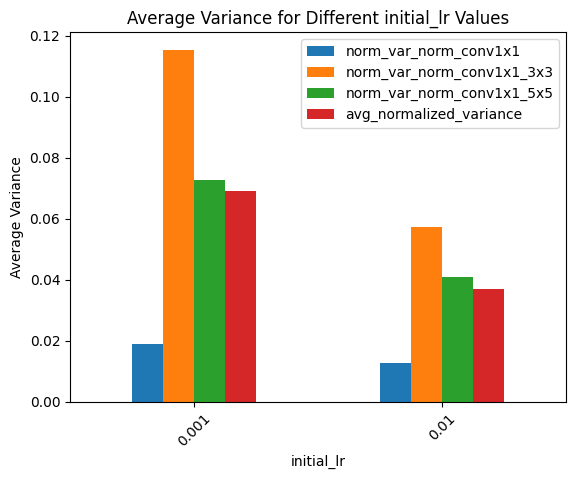

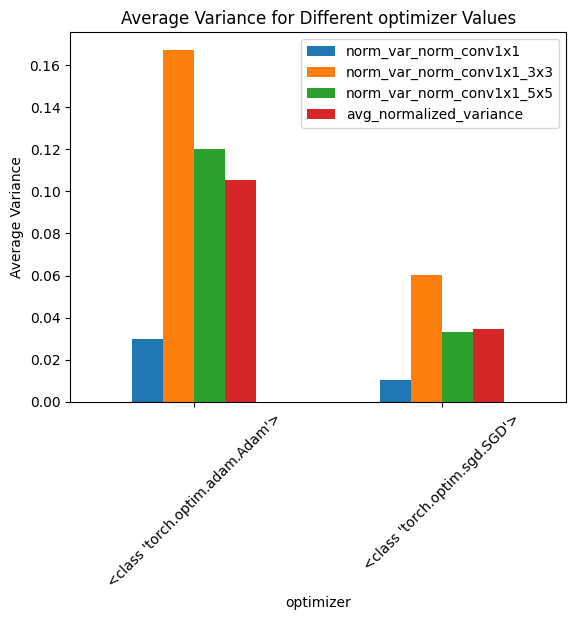

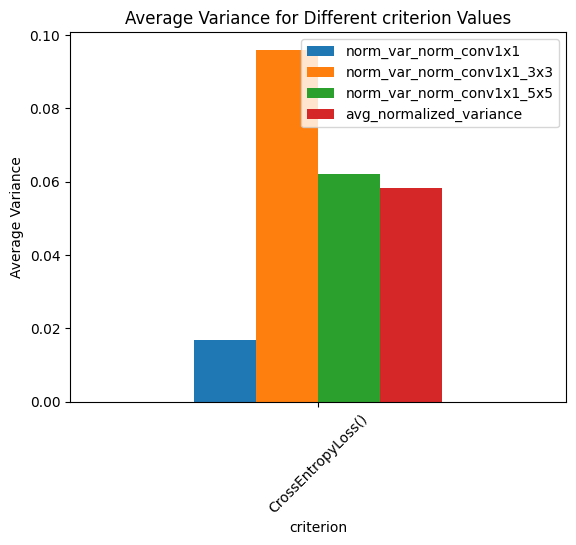

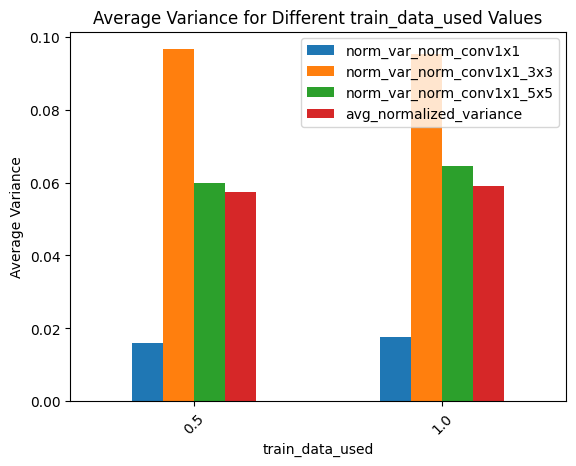

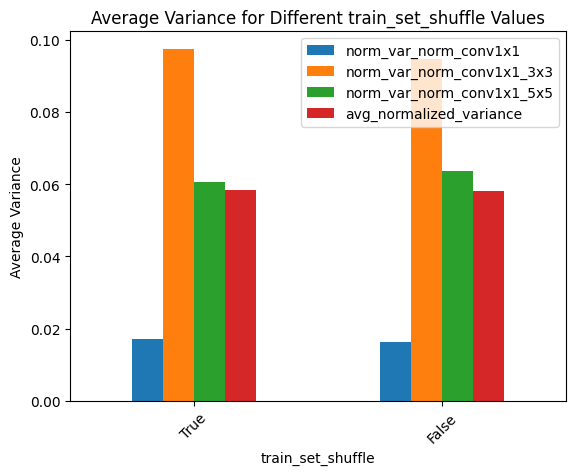

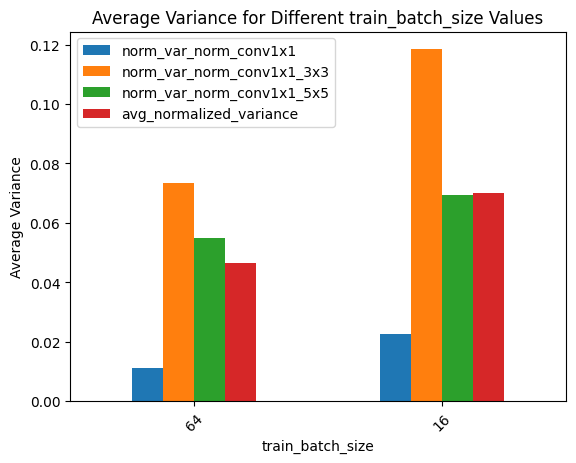

In [ ]:
hyperparams_choice_list = {
    'initial_lr': [0.001, 0.01],
    'optimizer': ['<class \'torch.optim.adam.Adam\'>', '<class \'torch.optim.sgd.SGD\'>'],
    'criterion': ['CrossEntropyLoss()'],
    'train_data_used': [0.5, 1],
    'train_set_shuffle': [True, False],
    'train_batch_size': [64, 16]
}

for hyperparam, variables in hyperparams_choice_list.items():
    plot_variance_for_multiple_hyperparam_values(filtered_integrated_gradients, hyperparam, variables)

# T test

In [ ]:
def perform_t_test(df, target_column, condition_column, choice1, choice2):
    # Splitting the data into two groups based on the condition
    group1 = df[df[condition_column] == choice1][target_column]
    group2 = df[df[condition_column] == choice2][target_column]

    # Performing the independent t-test
    t_statistic, p_value = ttest_ind(group1, group2)

    return t_statistic, p_value

In [ ]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'train_data_used', 1, 0.5)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 0.0941293181167861 P-value: 0.9258584747505212


In [ ]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'initial_lr', 0.01, 0.001)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -2.017862797922874 P-value: 0.055964444654046


In [ ]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'train_set_shuffle', True, False)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: 0.010901215068900235 P-value: 0.9914005137291451


In [ ]:
result = perform_t_test(filtered_integrated_gradients, 'avg_normalized_variance', 'train_batch_size', 64, 16)
print("T-statistic:", result[0], "P-value:", result[1])

T-statistic: -1.521192210723861 P-value: 0.14245555875511948


# Paired T test

In [ ]:
def find_rows_with_fixed_conditions(df, conditions):
    # Filter the DataFrame based on the conditions
    filtered_df = df
    for column, value in conditions.items():
        filtered_df = filtered_df[filtered_df[column] == value]

    return filtered_df

In [ ]:
def generate_hyperparameter_combinations(hyperparams):
    """
    Generate a sequence of hyperparameter combinations.

    :param hyperparams: A dictionary where keys are the names of hyperparameters,
                        and values are lists of possible choices for each hyperparameter.
    :return: A list of dictionaries, each representing a unique combination of hyperparameters.
    """
    # Extract the hyperparameter names and their corresponding choices
    keys, values = zip(*hyperparams.items())

    # Generate all possible combinations of hyperparameter values
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    return all_combinations

In [ ]:
def get_all_pairs(df, hyperparams_choice_list, target_column, condition_column, choice1, choice2):
    hyperparams_choice_list_compressed = {key: value for key, value in hyperparams_choice_list.items() if key != condition_column}
    all_combinations = generate_hyperparameter_combinations(hyperparams_choice_list_compressed)
    choice1_target_values=[]
    choice2_target_values=[]
    for conditions in all_combinations:
      x = find_rows_with_fixed_conditions(df, conditions)
      try:
        choice1_value = float(x[x[condition_column] == choice1][target_column])
        choice2_value = float(x[x[condition_column] == choice2][target_column])
        print(choice1_value, choice2_value)
      except:
        continue
      choice1_target_values.append(choice1_value)
      choice2_target_values.append(choice2_value)
    return choice1_target_values, choice2_target_values

train_data_used

In [ ]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, target_column='avg_normalized_variance', condition_column='train_data_used', choice1=1, choice2=0.5)
t_statistic, p_value = ttest_rel(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "P-value:", p_value)

0.0721691784342117 0.0727645558626717
0.1438675265228197 0.1326934478834252
0.0779516031935634 0.074597888603976
0.1378302121840579 0.1329322346061768
0.0318872134992179 0.0319004240289428
0.0335207891044199 0.0335453209933249
0.0319129375204851 0.0319346177907393
0.0320403099887209 0.0321685217706261
0.0338737752815797 0.0337729645758598
0.0404312722639129 0.0405077659818874
0.0328778445975866 0.033008246441001
0.0406923502339401 0.0408596708042588
T-statistic: 1.5283997603041448 P-value: 0.1546446773780158


initial_lr

In [ ]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'initial_lr', 0.01, 0.001)
t_statistic, p_value = ttest_rel(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "P-value:", p_value)

0.0337729645758598 0.0319004240289428
0.0405077659818874 0.0335453209933249
0.033008246441001 0.0319346177907393
0.0408596708042588 0.0321685217706261
0.0338737752815797 0.0318872134992179
0.0404312722639129 0.0335207891044199
0.0328778445975866 0.0319129375204851
0.0406923502339401 0.0320403099887209
T-statistic: 3.7883128584163073 P-value: 0.006817890707485202


train_set_shuffle

In [ ]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'train_set_shuffle', True, False)
t_statistic, p_value = ttest_rel(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "P-value:", p_value)

0.0727645558626717 0.074597888603976
0.1326934478834252 0.1329322346061768
0.0721691784342117 0.0779516031935634
0.1438675265228197 0.1378302121840579
0.0319004240289428 0.0319346177907393
0.0335453209933249 0.0321685217706261
0.0318872134992179 0.0319129375204851
0.0335207891044199 0.0320403099887209
0.0337729645758598 0.033008246441001
0.0405077659818874 0.0408596708042588
0.0338737752815797 0.0328778445975866
0.0404312722639129 0.0406923502339401
T-statistic: 0.22951756277881752 P-value: 0.8226785368835063


train_batch_size

In [ ]:
data_pairs=get_all_pairs(filtered_integrated_gradients, hyperparams_choice_list, 'avg_normalized_variance', 'train_batch_size', 64, 16)
t_statistic, p_value = ttest_rel(data_pairs[0], data_pairs[1])
print("T-statistic:", t_statistic, "P-value:", p_value)

0.0727645558626717 0.1326934478834252
0.074597888603976 0.1329322346061768
0.0721691784342117 0.1438675265228197
0.0779516031935634 0.1378302121840579
0.0319004240289428 0.0335453209933249
0.0319346177907393 0.0321685217706261
0.0318872134992179 0.0335207891044199
0.0319129375204851 0.0320403099887209
0.0337729645758598 0.0405077659818874
0.033008246441001 0.0408596708042588
0.0338737752815797 0.0404312722639129
0.0328778445975866 0.0406923502339401
T-statistic: -2.805665518480749 P-value: 0.017100587931732632
